<a href="https://colab.research.google.com/github/fatemehziaei/machine-learning/blob/main/fatemehZiaeiMoghaddam_project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import EMNIST
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


In [ ]:
def plot_results(train_losses, train_accs, val_losses, val_accs):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label='Train')
    axes[0].plot(xs, val_losses, label='Validation')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label='Train')
    axes[1].plot(xs, val_accs, label='Validation')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

First we , obtain the EMNIST dataset from its official source and load it into memory. Next, we process the image data by scaling pixel intensities to a standardized range and adjusting the data structure to match the model's input requirements.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

first_train_dataset = EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform)
test_dataset = EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform)

print(f'Train dataset size: {len(first_train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

classes = first_train_dataset.classes
print(f'Classes:\n{classes}')




100%|██████████| 562M/562M [00:11<00:00, 48.2MB/s]


Train dataset size: 112800
Test dataset size: 18800
Classes:
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


Visualizing some sample images to understand the dataset.

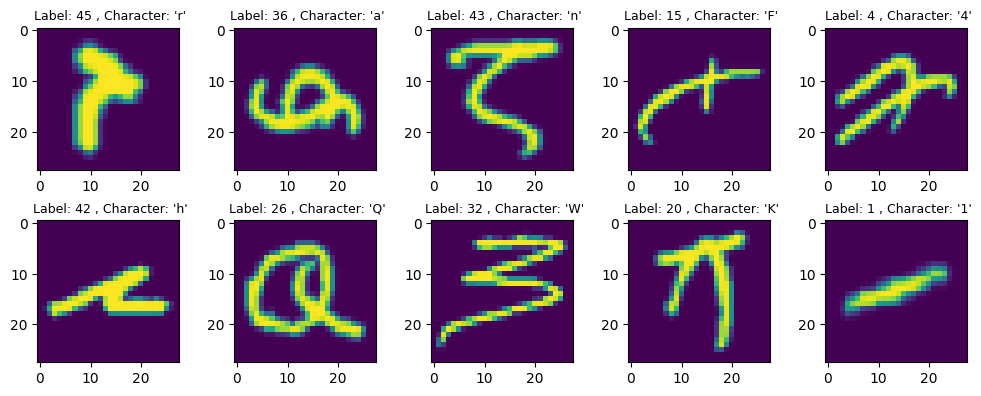

In [ ]:
fig,ax=plt.subplots(2, 5,figsize=(10,4))
for i in range(0,10):
  x,label=first_train_dataset[i]
  class_name=classes[label]
  ax[i//5,i%5].imshow(x[0,:,:])
  ax[i//5,i%5].set_title(f" Label: {label} , Character: '{class_name}'", fontsize=9)
plt.tight_layout()
plt.show()


Dividing the dataset into training, validation, and testing portions

In [ ]:
train_size = int(0.8 * len(first_train_dataset))
val_size = len(first_train_dataset) - train_size


ind=range(len(first_train_dataset))

# Split indices (stratified by class to maintain distribution)
train_idx, val_idx = train_test_split(ind, test_size=0.2, random_state=42)

# Create subset datasets
train_dataset = Subset(first_train_dataset, train_idx)
val_dataset = Subset(first_train_dataset, val_idx)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)
# Iterate over the data
for x, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {x.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Specifying the architectural structure of a deep learning model that processes data through hierarchical feature extraction using convolutional operations, nonlinear activation functions, and spatial pooling mechanisms.

In [ ]:
class ConvNN(nn.Module):
    def __init__(self, num_classes):
        super(ConvNN, self).__init__()

        self.network = nn.Sequential(
            # --- Convolution layers ---
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # (1,28,28) -> (32,28,28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),  # (32,28,28) -> (64,28,28)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (64,14,14)

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1), # (64,14,14) -> (128,14,14)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1), # (128,14,14) -> (256,14,14)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # (128,7,7)

            nn.Flatten(),

            # --- Fully Connected layers ---
            nn.Linear(256 * 7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)

implementing the iterative optimization procedure involving forward propagation, loss computation, backpropagation, and parameter updates

In [ ]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def val_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Iterate over the dataloader
    with torch.no_grad():
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Compute prediction error
          loss = criterion(pred, y)
          # Update the running loss
          running_loss += loss.item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    targets=[]
    preds=[]
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
          targets.extend(y.cpu().numpy())
          preds.extend(pred.argmax(1).cpu().numpy())
    print("confusion matrix:")
    print(confusion_matrix(targets,preds))
    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader,val_loader,test_loader,early_stopping_patience=10, device=device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc=0
    patience=0
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Validation Loss = {val_loss:.3f} | Validation Acc = {val_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), val_losses.append(val_loss), val_accs.append(val_acc)
        if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), "best_model.pth")
          patience=0
        else:
          patience+=1
          if patience >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch+1} epochs")
                    break

    # Plot the results
    plot_results(train_losses, train_accs, val_losses, val_accs)
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = test_step(model, criterion, test_loader)
    print(f"test_loss={test_loss} and test_accuracy ={test_acc}")
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

the loss curves show that after epoch 5, the CNN is overfitted.

Train Loss = 0.141 | Train Acc = 94.23% | Validation Loss = 0.461 | Validation Acc = 88.72% : 100%|██████████| 20/20 [12:27<00:00, 37.37s/it]


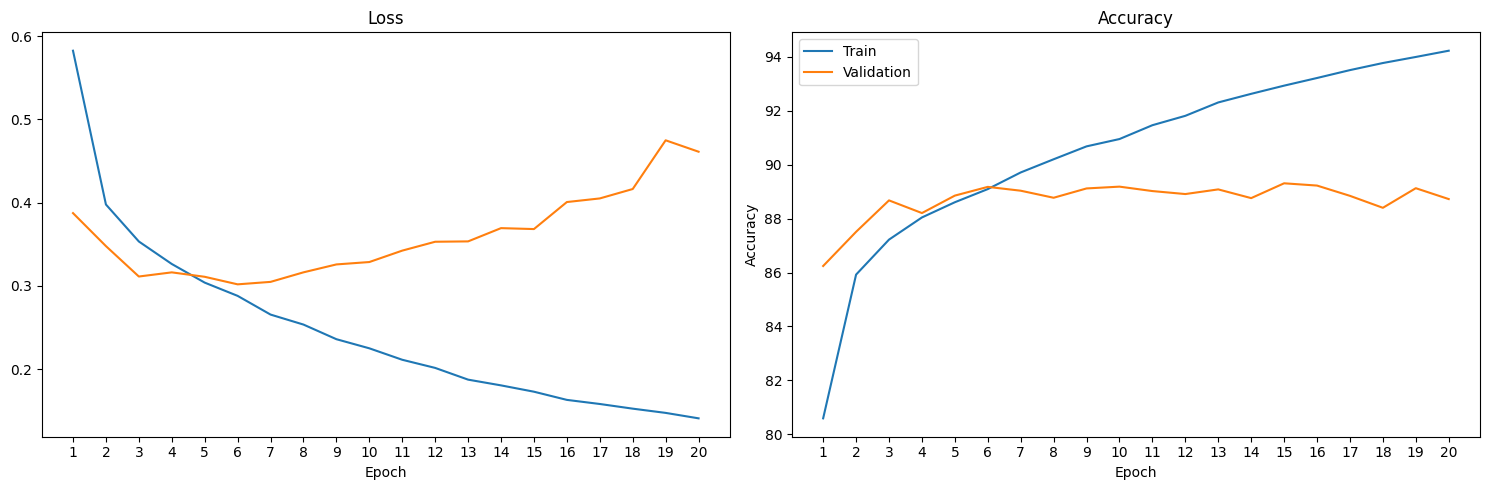

confusion matrix:
[[276   0   0 ...   0   0   0]
 [  0 253   0 ...   0   0   1]
 [  0   0 352 ...   0   0   0]
 ...
 [  0   0   1 ... 201   0   0]
 [  0   0   0 ...   0 376   0]
 [  0   1   0 ...   0   4 361]]
test_loss=0.4065729021569904 and test_accuracy =88.62765957446808


In [ ]:
model = ConvNN(num_classes=len(classes)).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)

results = train_model(model, 20, optimizer, train_loader, val_loader,test_loader,early_stopping_patience=10)



Initializing wandb for continuous monitoring of training and validation performance metrics including loss values and accuracy percentages

In [ ]:
import wandb
import os

# Login to wandb (you'll need an API key from https://wandb.ai/authorize)
wandb.login()

# Set up environment variables (optional but recommended)
os.environ["WANDB_PROJECT"] = "cnn-wandb"  # project's name
os.environ["WANDB_ENTITY"] = "Fatemeh"     #username
os.environ["WANDB_LOG_MODEL"] = "true"          # Log model checkpoints
os.environ["WANDB_WATCH"] = "all"               # Log all gradients and parameters

# 1. Initialize wandb
wandb.init(project="cnn-wandb",name="using wandb",
           notes="CNN model for image classification using wandb to log metrics such as training/validation loss and accuracy",
           config={"learning_rate": 0.001,"batch_size": 64,"epochs": 10,"optimizer": "Adam",
           "architecture": "customCNN","dataset": "EMNIST"})

#config parameters
config = wandb.config


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: f-ziaeim (f-ziaeim-amirkabir-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def val_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.eval()
    # Iterate over the dataloader
    with torch.no_grad():
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Compute prediction error
          loss = criterion(pred, y)
          # Update the running loss
          running_loss += loss.item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device,class_names=classes):
    running_loss, correct = 0, 0
    predicted_labels = []
    target_labels = []
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(dim=1) == y).type(torch.float).sum().item()
          predicted_labels.extend(pred.argmax(dim=1).cpu().numpy())
          target_labels.extend(y.cpu().numpy())

    # Log confusion matrix
    wandb.log({"conf_mat_test": wandb.plot.confusion_matrix(y_true=target_labels,preds=predicted_labels,
              class_names=class_names)})

    # Calculate and return the average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(model, n_epochs, optimizer, train_loader,val_loader,test_loader, early_stopping_patience, device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc=0
    patience=0
    for epoch in (pbar := trange(n_epochs)):
        # Train the model
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        # Evaluate the model
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        # Display the results
        pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Validation Loss = {val_loss:.3f} | Validation Acc = {val_acc:.2f}% ')
        # Store the results
        train_losses.append(train_loss), train_accs.append(train_acc), val_losses.append(val_loss), val_accs.append(val_acc)
        # Log metrics to wandb
        wandb.log({"epoch": epoch,"train_loss": train_loss,"train_acc": train_acc,
                    "val_loss": val_loss,"val_acc": val_acc,"learning_rate": optimizer.param_groups[0]['lr']})
        if val_acc > best_acc:
          best_acc = val_acc
          torch.save(model.state_dict(), "best_model.pth")
          wandb.save("best_model.pth")  # Save to wandb
          patience=0
        else:
          patience+=1
          if patience >= early_stopping_patience:
             print(f"Early stopping triggered after {epoch+1} epochs")
             break

    # Plot the results
    plot_results(train_losses, train_accs, val_losses, val_accs)
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = test_step(model, criterion, test_loader,device,classes)
    wandb.log({"test_acc": test_acc,"test_loss": test_loss,"best_val_acc": val_acc})
    print(f"test_loss={test_loss} and test_accuracy ={test_acc}")
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs,'test_loss': test_loss, 'test_acc': test_acc}

Train Loss = 0.167 | Train Acc = 93.21% | Validation Loss = 0.314 | Validation Acc = 89.45% : 100%|██████████| 10/10 [06:30<00:00, 39.01s/it]


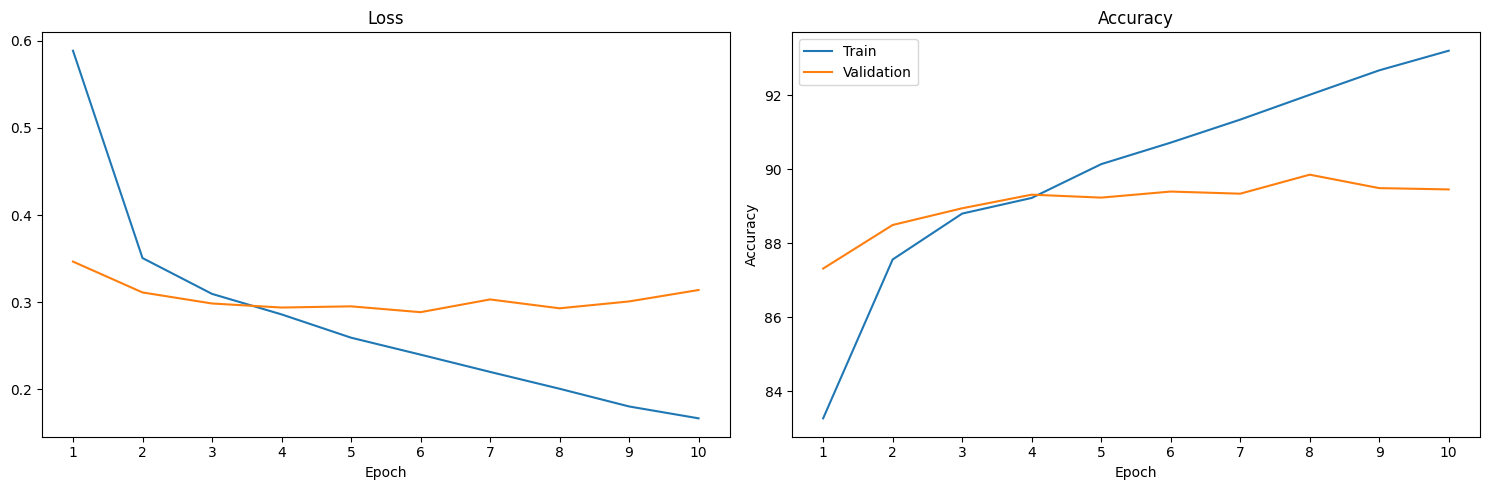

test_loss=0.3175637911827791 and test_accuracy =89.19148936170212


best_val_acc,▁
epoch,▁▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▁▄▅▅▆▆▇▇██▁▄▅▅▆▆▇▇██
train_loss,██▄▃▃▃▂▂▂▁▁█▄▃▃▃▂▂▂▁▁
val_acc,▂▄▅▅▆▇▇▇▇▇▇▁▄▅▇▆▇▇█▇▇
val_loss,█▆▄▃▂▁▁▂▂▂▄▇▄▂▂▂▁▃▂▂▄
best_val_acc,89.45479
epoch,9


In [ ]:
model = ConvNN(num_classes=len(classes)).to(device)
if config.optimizer == "Adam":
  optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
else:
  optimizer = optim.SGD(model.parameters(), lr=config.learning_rate)

results = train_model(model, config.epochs, optimizer, train_loader, val_loader,test_loader,10,device)
wandb.finish()

Leveraging wandb's sweep capability to methodically optimize key model parameters: learning rate, optimizer type, batch size options, convolution filters, dropout rates, and architectural configurations

In [ ]:
class convNN(nn.Module):
    def __init__(self, config, num_classes):
        super(convNN, self).__init__()
        input_size = 28
        output_size = input_size
        # --- Convolution layers ---
        layers = []
        n_input_ch = 1
        stride=config["stride"]
        padding=config["padding"]
        pool_size=config["pool_size"]
        for i in range(config["num_conv_layers"]):
            # Add convolutional layer
            n_out_ch=config["filters"] * (2 ** i)
            layers.append(nn.Conv2d(
                n_input_ch,n_out_ch,kernel_size=config["kernel_size"],
                padding=config["kernel_size"] // 2))
            layers.append(nn.BatchNorm2d(n_out_ch))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            # computing number of channels for next layer
            n_input_ch = n_out_ch
         #   output_size = (output_size + 2*padding - config["kernel_size"]) // stride + 1
            # MaxPool layer
         #   output_size = (output_size - pool_size) // pool_size + 1
            # Update output size

        dummy_input = torch.zeros(1, 1, 28, 28)  # (batch, channels, height, width)
        with torch.no_grad():
            featuremap_size = nn.Sequential(*layers)(dummy_input)

        self.flattened_size = int(torch.prod(torch.tensor(featuremap_size.shape[1:])))
        # Calculate flattened size for fully connected layer
      #  self.flattened_size = n_input_ch * output_size * output_size
        # CNN
        self.network = nn.Sequential(*layers,
            nn.Flatten(),
            nn.Linear(self.flattened_size, config["dense_units"]),
            nn.BatchNorm1d(config["dense_units"]),
            nn.ReLU(),
            nn.Dropout(config["dropout_rate"]),
            nn.Linear(config["dense_units"], num_classes)
        )

    def forward(self, x):
        x = self.network(x)
        return x

In [ ]:
def get_dataset(config):
    """Load and prepare EMNIST dataset"""
    train_size = int(config["train_ratio"] * len(first_train_dataset))
    val_size = len(first_train_dataset) - train_size
    ind=range(len(first_train_dataset))
    # Split indices
    train_idx, val_idx = train_test_split(ind, test_size=0.2, random_state=42)
    # Create subset datasets
    train_dataset = Subset(first_train_dataset, train_idx)
    val_dataset = Subset(first_train_dataset, val_idx)
    train_loader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=config["batch_size"], shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config["batch_size"], shuffle=False)
    num_classes=len(classes)
    return train_loader, val_loader, test_loader,num_classes

In [ ]:
def train_step(model, criterion, optimizer, dataloader, device=device):
    running_loss, correct = 0, 0
    # Move the model to training mode
    model.train()
    # Iterate over the dataloader
    for x, y in dataloader:
        # Move the datapoints to same device as the model
        x, y = x.to(device), y.to(device)
        # Clear the gradients
        optimizer.zero_grad()
        # Predict the output and perform the forward pass
        pred = model(x)
        # Compute prediction error
        loss = criterion(pred, y)
        # Backpropagation
        loss.backward()
        # Update the model weights
        optimizer.step()
        # Update the running loss
        running_loss += loss.item()
        # Update the correctly predicted counter
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

def val_step(model, criterion, dataloader, device=device):
    running_loss, correct = 0, 0
    preds = []
    targets = []
    # Move the model to training mode
    model.eval()
    # Iterate over the dataloader
    with torch.no_grad():
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Compute prediction error
          loss = criterion(pred, y)
          # Update the running loss
          running_loss += loss.item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate and return the average loss and accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def test_step(model, criterion, dataloader, device=device,class_names=None):
    running_loss, correct = 0, 0
    predicted_labels = []
    target_labels = []
    # Move the model to training mode
    model.eval()
    # Disable gradient calculation
    with torch.no_grad():
      # Iterate over the dataloader
      for x, y in dataloader:
          # Move the datapoints to same device as the model
          x, y = x.to(device), y.to(device)
          # Predict the output and perform the forward pass
          pred = model(x)
          # Update the running loss
          running_loss += criterion(pred, y).item()
          # Update the correctly predicted counter
          correct += (pred.argmax(1) == y).type(torch.float).sum().item()
          predicted_labels.extend(pred.argmax(1).cpu().numpy())
          target_labels.extend(y.cpu().numpy())

    # Log confusion matrix
    wandb.log({"test_conf_mat": wandb.plot.confusion_matrix(y_true=target_labels,preds=predicted_labels,class_names=class_names)})
    # return the loss and average accuracy
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)


def train_model(config=None):
    run = wandb.init()
    config = wandb.config
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    # Get cpu, gpu or mps device for training.
    device = ("cuda" if torch.cuda.is_available()
               else "mps" if torch.backends.mps.is_available()
               else "cpu")
    print(f"Using device: {device}")
    train_loader, val_loader, test_loader, num_classes = get_dataset(config)

    criterion = nn.CrossEntropyLoss()
    num_classes=len(classes)
    model = convNN(config, num_classes).to(device)
    # choose optimizer according to config
    if config.optimizer == "Adam":
        optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)
    else:  # SGD
        optimizer = optim.SGD(model.parameters(),lr=config.learning_rate)
    # Learning rate scheduler
#    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',patience=3,factor=0.5,)

    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc=0
    early_stopping_patience=10
    patience=0
    # Training loop
    for epoch in (pbar := trange(config.epochs)):
      # Train the model
      train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
      # Evaluate the model
      val_loss, val_acc = val_step(model, criterion, val_loader, device)
      # Display the results
      pbar.set_description(f'Train Loss = {train_loss:.3f} | Train Acc = {train_acc:.2f}% | Validation Loss = {val_loss:.3f} | Validation Acc = {val_acc:.2f}% ')
      # Store the results
      train_losses.append(train_loss)
      train_accs.append(train_acc)
      val_losses.append(val_loss)
      val_accs.append(val_acc)
      # Log metrics to wandb
      wandb.log({"epoch": epoch,"train_loss": train_loss,"train_acc": train_acc,
                 "val_loss": val_loss,"val_acc": val_acc,"learning_rate": optimizer.param_groups[0]['lr']})
      # Update learning rate
  #    scheduler.step(val_acc)
      if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        artifact = wandb.Artifact(f"best-model.pth", type="model")
        wandb.log_artifact(artifact)
        patience=0
      else:
        patience+=1
        if patience >= early_stopping_patience:
           print(f"Early stopping triggered after {epoch+1} epochs")
           break

    # Plot the results
    plot_results(train_losses, train_accs, val_losses, val_accs)
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = test_step(model, criterion, test_loader,device=device,class_names=classes)
    print(f"test_loss={test_loss} and test_accuracy ={test_acc}")
    wandb.log({"test_acc": test_acc, "test_loss": test_loss, "best_val_acc": best_acc})
    return {"train_loss":np.mean(train_loss),"train_acc":np.mean(train_acc),"val_acc": best_acc,"test_acc": test_acc,"test_loss": test_loss}



Create sweep with ID: nfhw9t5s
Sweep URL: https://wandb.ai/f-ziaeim-amirkabir-university-of-technology/sweep-cnn/sweeps/nfhw9t5s
Sweep ID: nfhw9t5s
Starting 20 runs for hyperparameter sweep...


wandb: Agent Starting Run: 4fvgxftk with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 32
wandb: 	dropout_rate: 0.490446931576084
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.002077517782140712
wandb: 	num_conv_layers: 2
wandb: 	optimizer: SGD
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 1.220 | Train Acc = 63.37% | Validation Loss = 0.612 | Validation Acc = 84.21% : 100%|██████████| 15/15 [06:42<00:00, 26.82s/it]


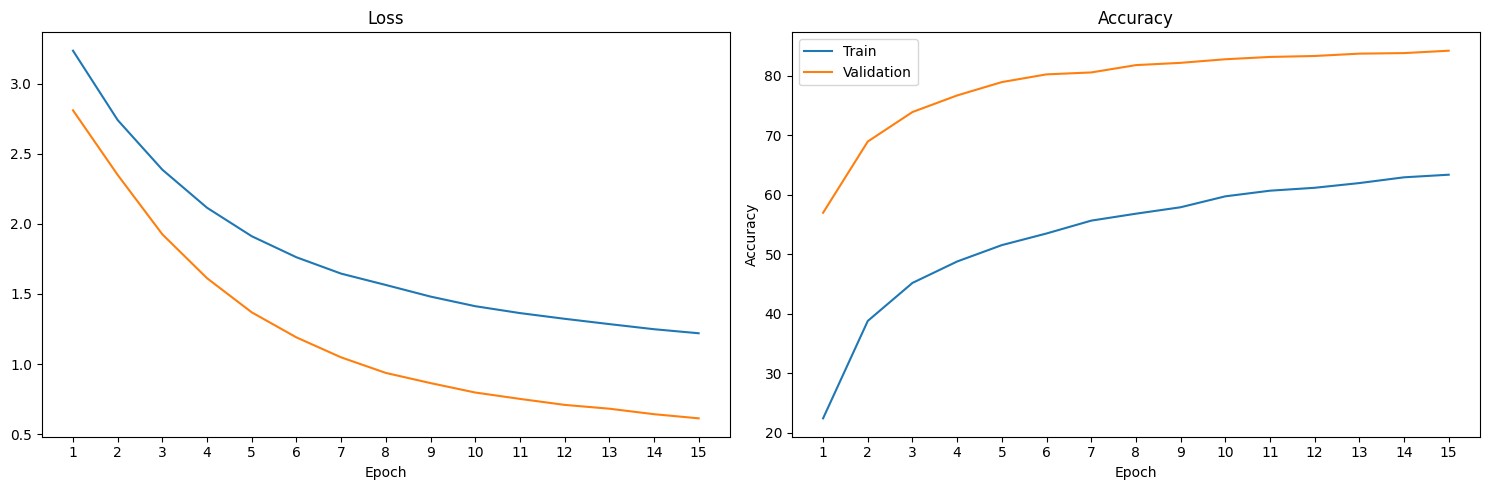

test_loss=0.6256489928076867 and test_accuracy =83.8563829787234


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▆▆▇▇▇▇█████
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇▇██████
val_loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁
best_val_acc,84.21099
epoch,14


wandb: Agent Starting Run: 90jfxqox with config:
wandb: 	batch_size: 16
wandb: 	dense_units: 32
wandb: 	dropout_rate: 0.20487983409780647
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 4.021695121079043e-06
wandb: 	num_conv_layers: 4
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 1.237 | Train Acc = 79.88% | Validation Loss = 0.991 | Validation Acc = 83.96% : 100%|██████████| 15/15 [11:58<00:00, 47.93s/it]


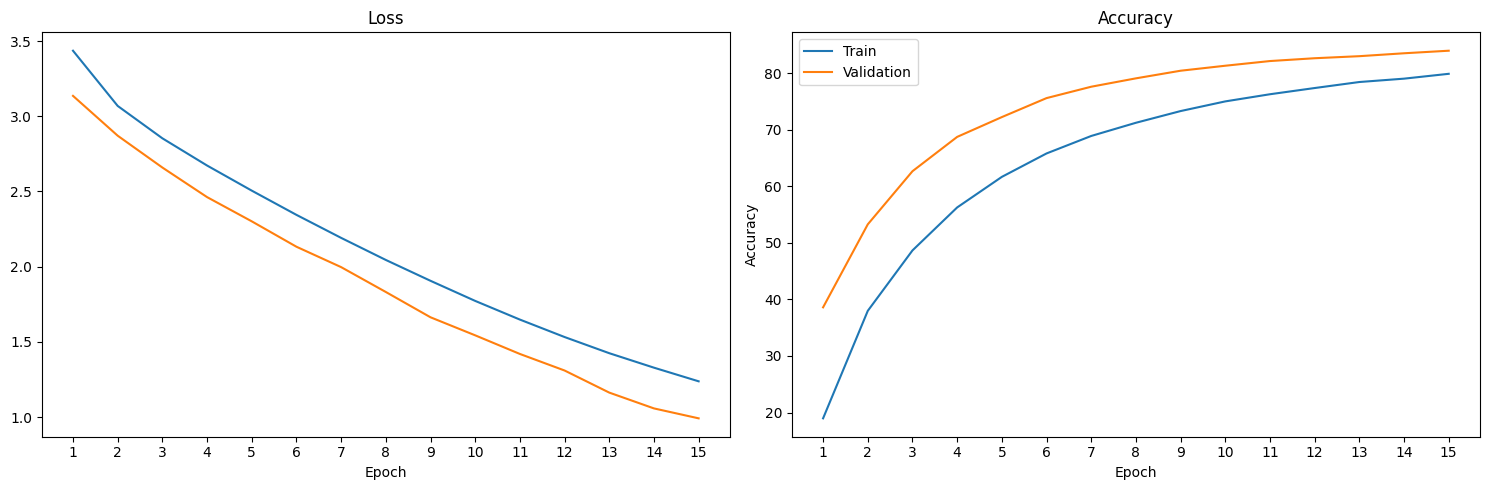

test_loss=1.0011210484200335 and test_accuracy =83.27659574468085


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▆▆▇▇▇▇█████
train_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
val_acc,▁▃▅▆▆▇▇▇▇██████
val_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
best_val_acc,83.96277
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bsqm5va5 with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.37991409930187847
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 3
wandb: 	learning_rate: 8.046834019953142e-06
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.744 | Train Acc = 80.13% | Validation Loss = 0.604 | Validation Acc = 83.52% : 100%|██████████| 15/15 [07:43<00:00, 30.90s/it]


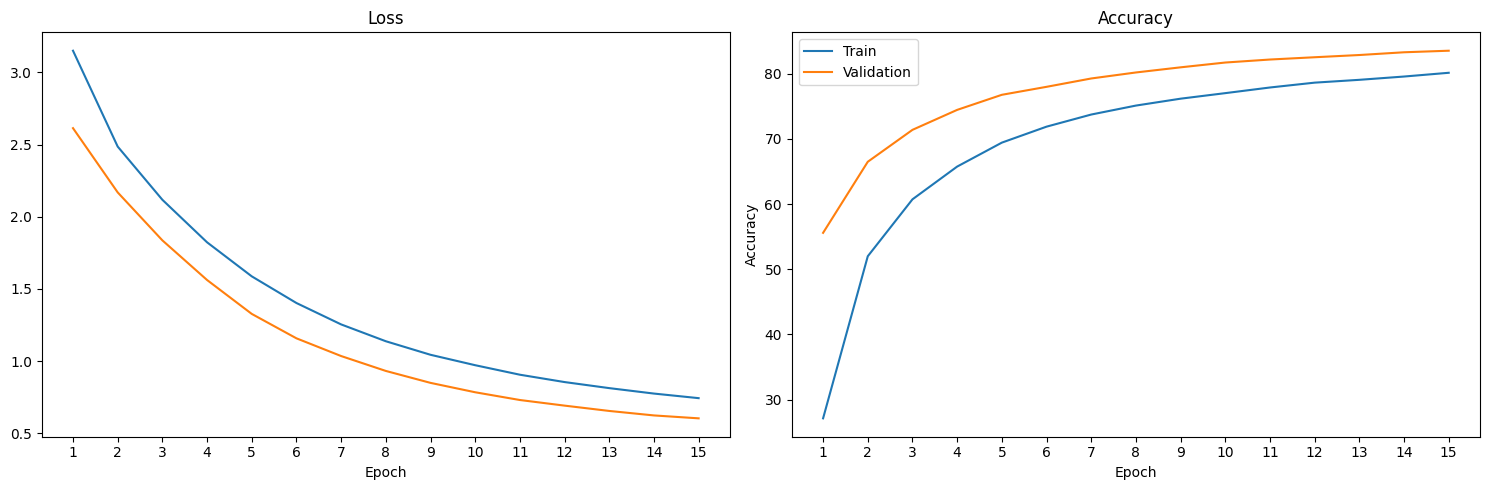

test_loss=0.6170785606008808 and test_accuracy =83.19148936170212


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▄▅▆▇▇▇▇▇██████
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇██████
val_loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
best_val_acc,83.5195
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: khk3loyw with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3970159569749153
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	kernel_size: 5
wandb: 	learning_rate: 7.786916650433777e-06
wandb: 	num_conv_layers: 3
wandb: 	optimizer: SGD
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 3.211 | Train Acc = 24.28% | Validation Loss = 3.129 | Validation Acc = 34.06% : 100%|██████████| 15/15 [09:16<00:00, 37.09s/it]


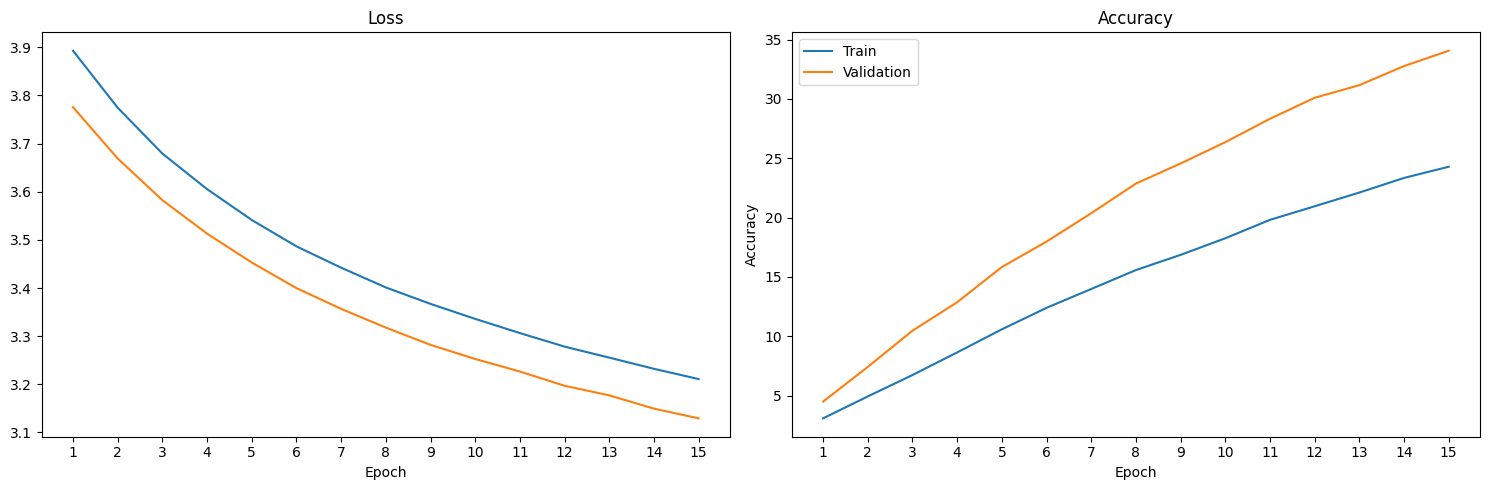

test_loss=3.1348398571111717 and test_accuracy =33.90425531914894


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▂▂▃▃▄▅▅▆▆▇▇▇██
train_loss,█▇▆▅▄▄▃▃▃▂▂▂▁▁▁
val_acc,▁▂▂▃▄▄▅▅▆▆▇▇▇██
val_loss,█▇▆▅▅▄▃▃▃▂▂▂▂▁▁
best_val_acc,34.06028
epoch,14


wandb: Agent Starting Run: 9z6xzbsl with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3724703656081492
wandb: 	epochs: 15
wandb: 	filters: 32
wandb: 	kernel_size: 3
wandb: 	learning_rate: 1.2879143803432503e-05
wandb: 	num_conv_layers: 3
wandb: 	optimizer: SGD
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 3.353 | Train Acc = 18.29% | Validation Loss = 3.280 | Validation Acc = 26.52% : 100%|██████████| 15/15 [07:12<00:00, 28.83s/it]


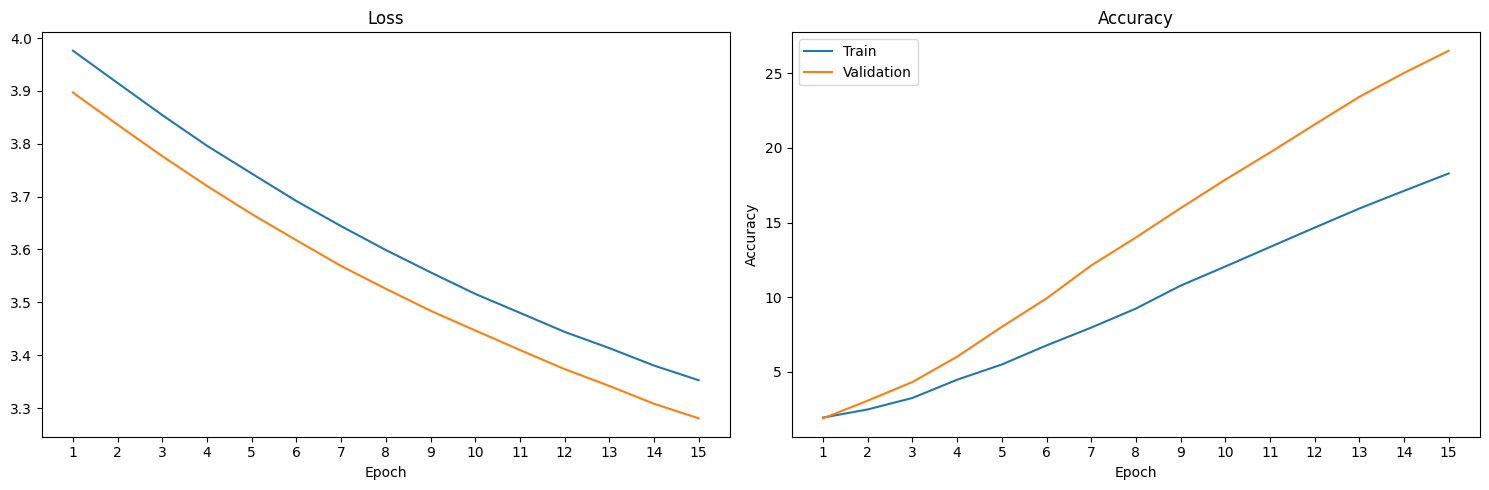

test_loss=3.283113350673598 and test_accuracy =26.409574468085108


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▁▂▂▃▃▄▄▅▅▆▆▇██
train_loss,█▇▇▆▅▅▄▄▃▃▂▂▂▁▁
val_acc,▁▁▂▂▃▃▄▄▅▆▆▇▇██
val_loss,█▇▇▆▅▅▄▄▃▃▂▂▂▁▁
best_val_acc,26.51596
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4cejwx4x with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.4835280875115662
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005282569398440498
wandb: 	num_conv_layers: 2
wandb: 	optimizer: SGD
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 2.053 | Train Acc = 58.05% | Validation Loss = 1.834 | Validation Acc = 73.30% : 100%|██████████| 15/15 [06:25<00:00, 25.72s/it]


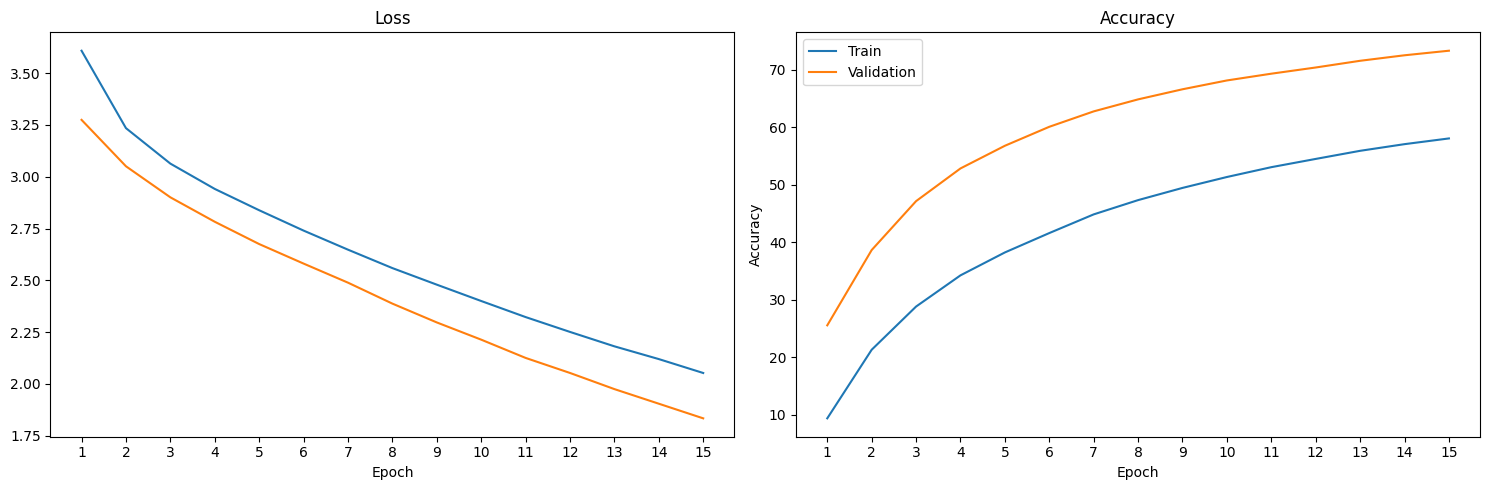

test_loss=1.8462905616176373 and test_accuracy =73.01063829787235


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▃▄▅▅▆▆▆▇▇▇▇███
train_loss,█▆▆▅▅▄▄▃▃▃▂▂▂▁▁
val_acc,▁▃▄▅▆▆▆▇▇▇▇████
val_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
best_val_acc,73.29787
epoch,14


wandb: Agent Starting Run: ztl58q1y with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.4225398761731128
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 2.8147299605676596e-05
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.469 | Train Acc = 85.13% | Validation Loss = 0.387 | Validation Acc = 86.88% : 100%|██████████| 15/15 [06:57<00:00, 27.85s/it]


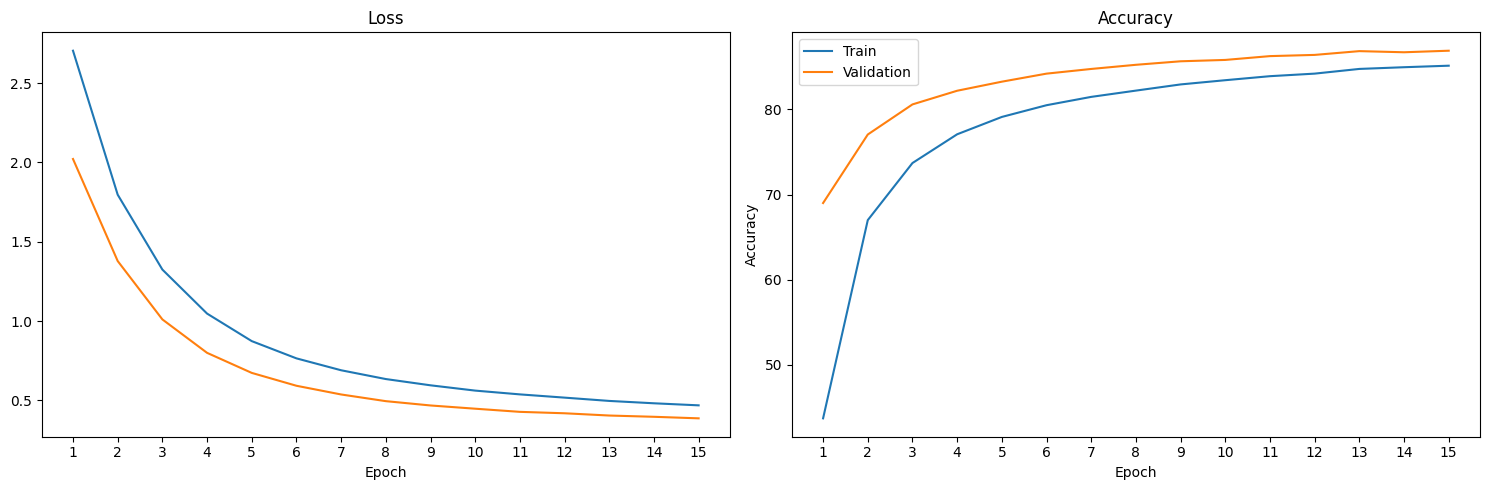

test_loss=0.4086469763598474 and test_accuracy =86.32446808510639


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇▇▇▇████████
train_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇███████
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁
best_val_acc,86.88387
epoch,14


wandb: Agent Starting Run: l37nycsq with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.41375204293421913
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 9.94111683334712e-05
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.335 | Train Acc = 88.18% | Validation Loss = 0.325 | Validation Acc = 88.28% : 100%|██████████| 15/15 [06:55<00:00, 27.71s/it]


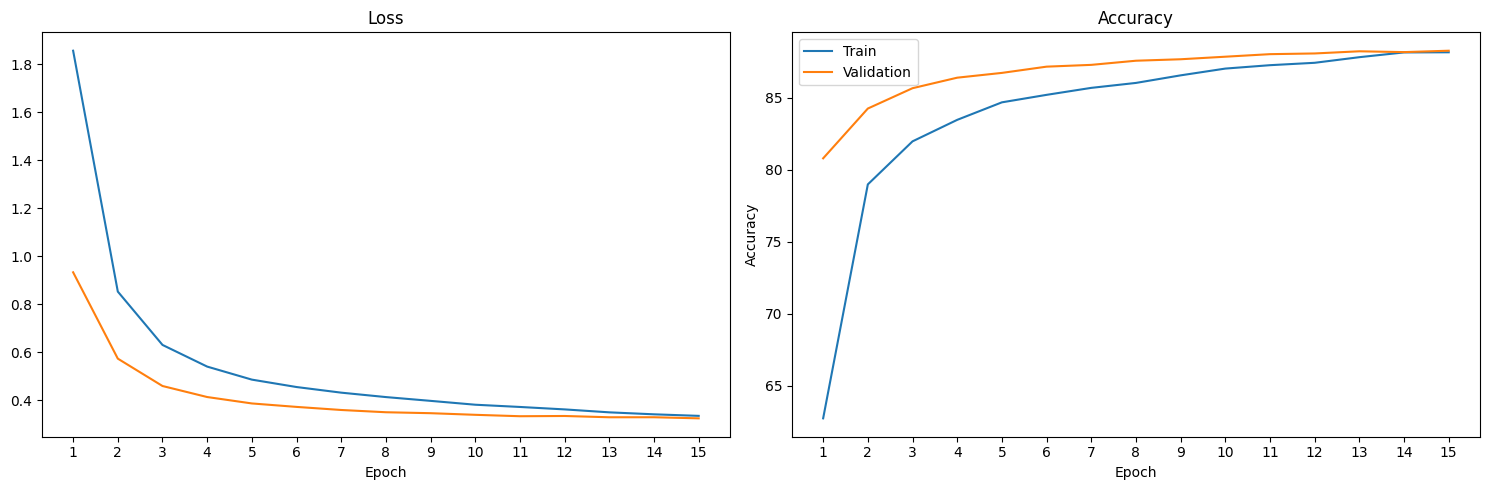

test_loss=0.3459535597183672 and test_accuracy =87.95744680851064


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇▇▇▇▇███████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇▇██████
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
best_val_acc,88.28457
epoch,14


wandb: Agent Starting Run: a4u4mhpp with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.4142440415928856
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 6.501930110014023e-05
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.367 | Train Acc = 87.35% | Validation Loss = 0.336 | Validation Acc = 87.93% : 100%|██████████| 15/15 [06:54<00:00, 27.63s/it]


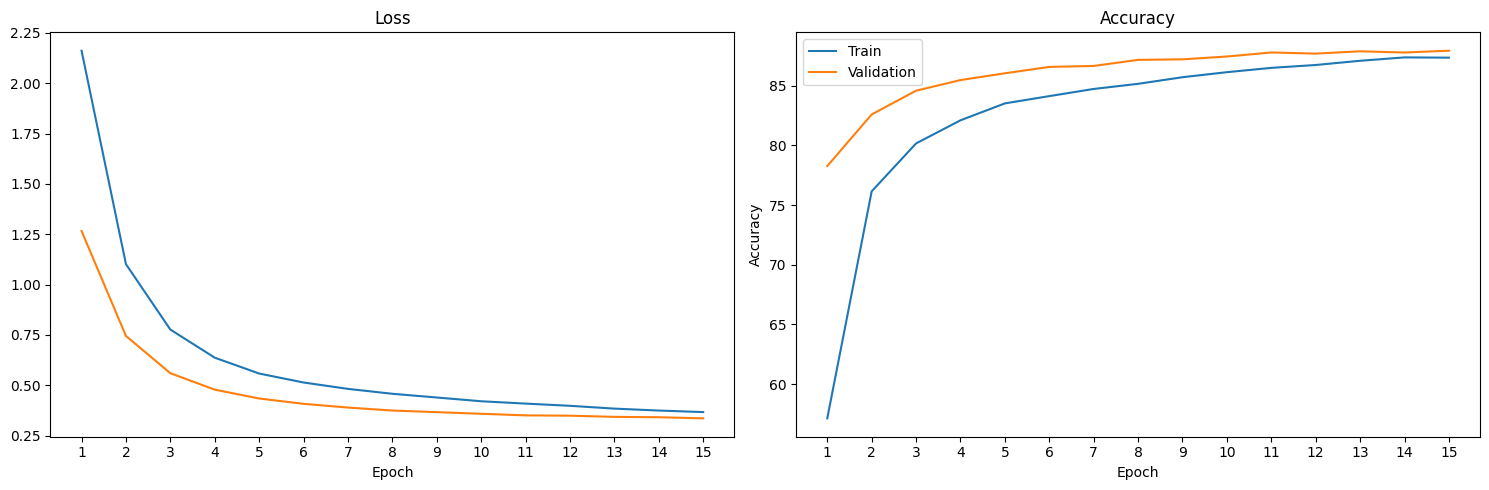

test_loss=0.3562944406250707 and test_accuracy =87.76063829787235


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇▇██████
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
best_val_acc,87.9344
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ybm3xg3 with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.3663076202241956
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0012768748948926792
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.246 | Train Acc = 90.48% | Validation Loss = 0.328 | Validation Acc = 88.68% : 100%|██████████| 15/15 [06:53<00:00, 27.57s/it]


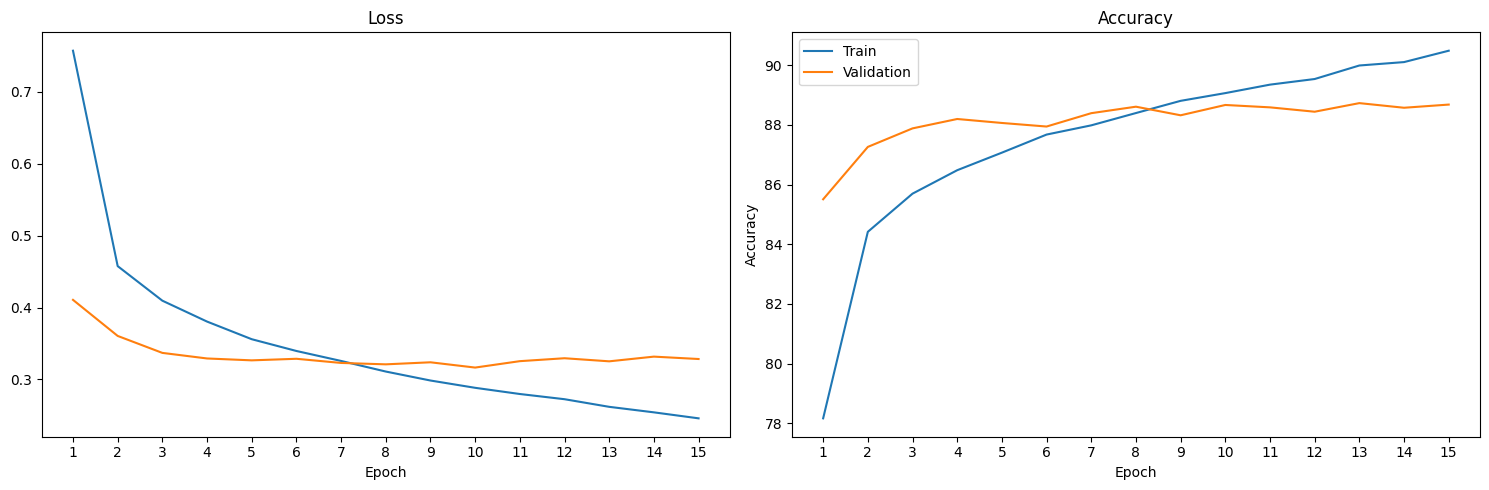

test_loss=0.3486004106345631 and test_accuracy =88.09574468085107


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▅▆▆▆▇▇▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇▆▇█▇██▇███
val_loss,█▄▃▂▂▂▁▁▂▁▂▂▂▂▂
best_val_acc,88.72784
epoch,14


wandb: Agent Starting Run: bt7g891m with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.39193947207106905
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0012197153039970664
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.277 | Train Acc = 89.30% | Validation Loss = 0.321 | Validation Acc = 88.86% : 100%|██████████| 15/15 [07:53<00:00, 31.54s/it]


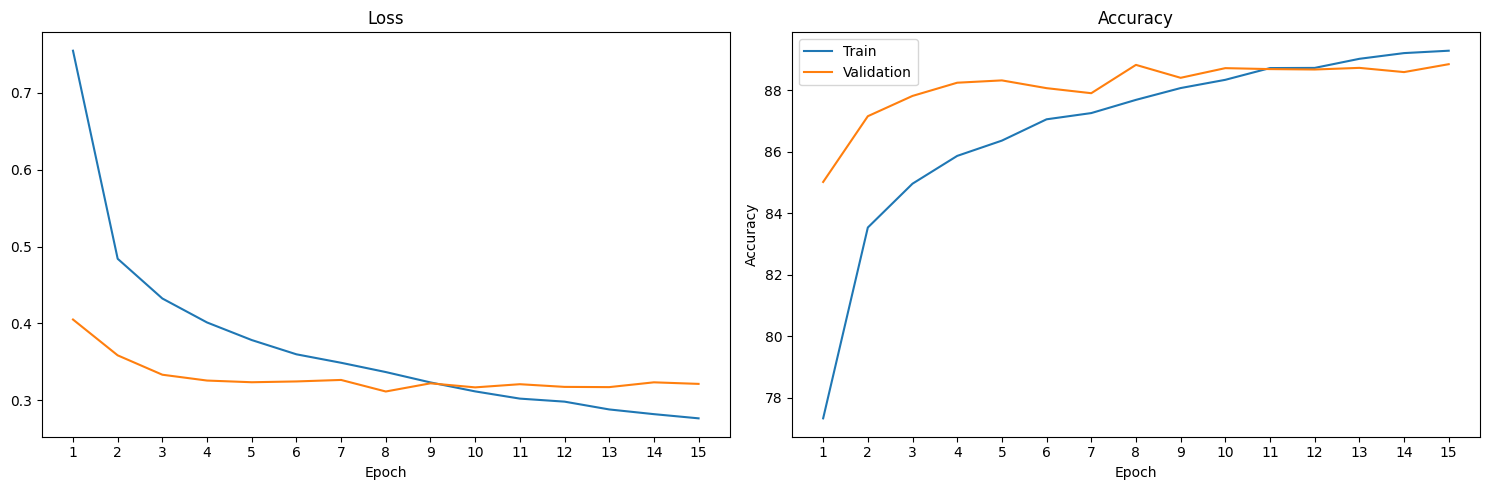

test_loss=0.34338280443913066 and test_accuracy =88.55851063829788


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▅▆▆▇▇▇▇▇█████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇▇▆█▇██████
val_loss,█▅▃▂▂▂▂▁▂▁▂▁▁▂▂
best_val_acc,88.85638
epoch,14


wandb: Agent Starting Run: hqybakim with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.33851998167364195
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 2.9846233262279472e-05
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.417 | Train Acc = 86.53% | Validation Loss = 0.373 | Validation Acc = 87.23% : 100%|██████████| 15/15 [06:50<00:00, 27.40s/it]


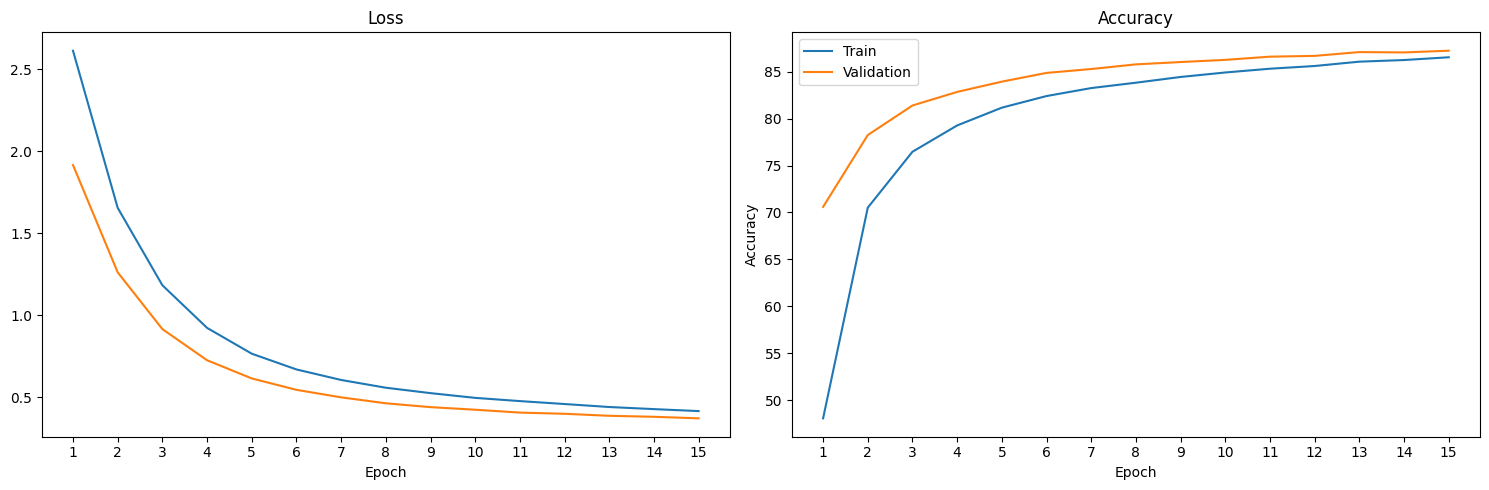

test_loss=0.39512001748393183 and test_accuracy =86.69148936170212


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇▇▇▇████████
train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇▇██████
val_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
best_val_acc,87.22961
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mkuzu4lf with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3063536080631522
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0005039972913959488
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.320 | Train Acc = 88.22% | Validation Loss = 0.329 | Validation Acc = 88.49% : 100%|██████████| 15/15 [07:48<00:00, 31.25s/it]


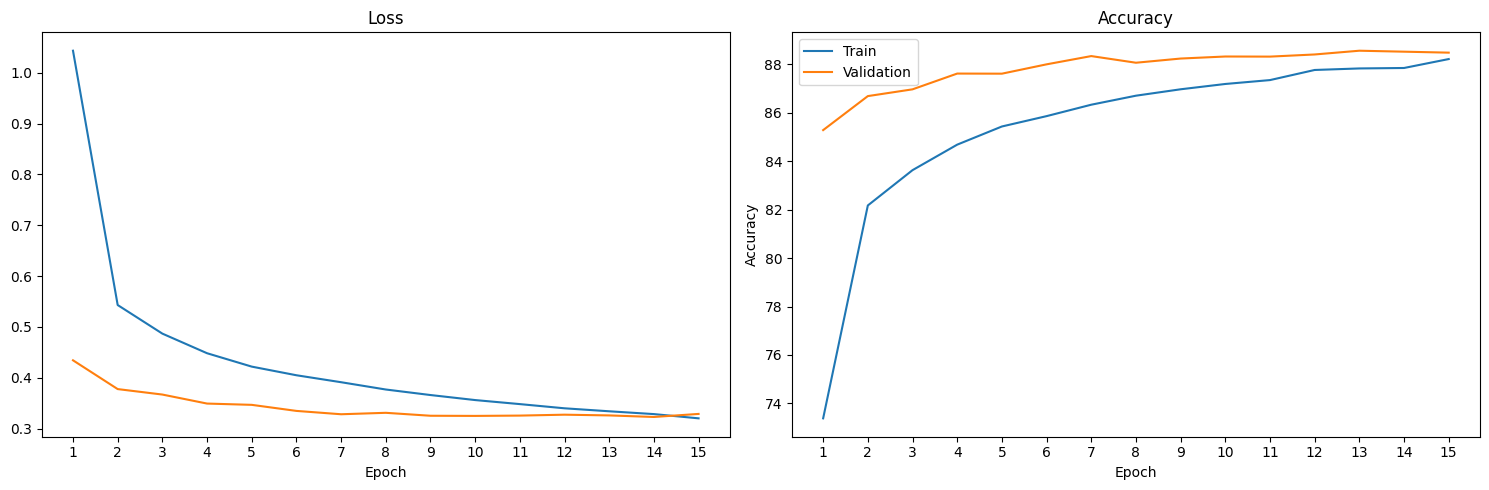

test_loss=0.35313624452774217 and test_accuracy =88.07978723404256


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▆▇▇▇▇▇██████
train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇█▇▇▇▇████
val_loss,█▄▄▃▂▂▁▂▁▁▁▁▁▁▁
best_val_acc,88.56826
epoch,14


wandb: Agent Starting Run: nkzq15pw with config:
wandb: 	batch_size: 128
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.46210966880368215
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 2.913996985819635e-05
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.558 | Train Acc = 83.54% | Validation Loss = 0.442 | Validation Acc = 86.17% : 100%|██████████| 15/15 [06:22<00:00, 25.51s/it]


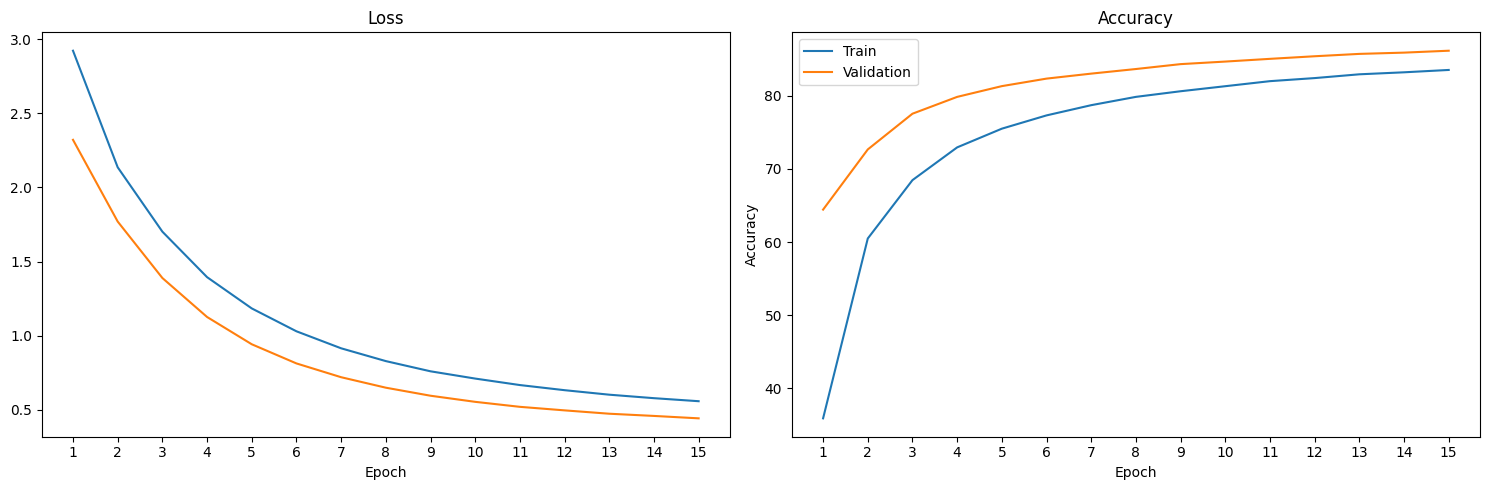

test_loss=0.4623624789877003 and test_accuracy =85.44680851063829


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▆▇▇▇▇███████
train_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇██████
val_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁
best_val_acc,86.17465
epoch,14


wandb: Agent Starting Run: 66iq0ua8 with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.46711980211364235
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.00015334514029254515
wandb: 	num_conv_layers: 3
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.372 | Train Acc = 86.96% | Validation Loss = 0.313 | Validation Acc = 88.63% : 100%|██████████| 15/15 [08:30<00:00, 34.06s/it]


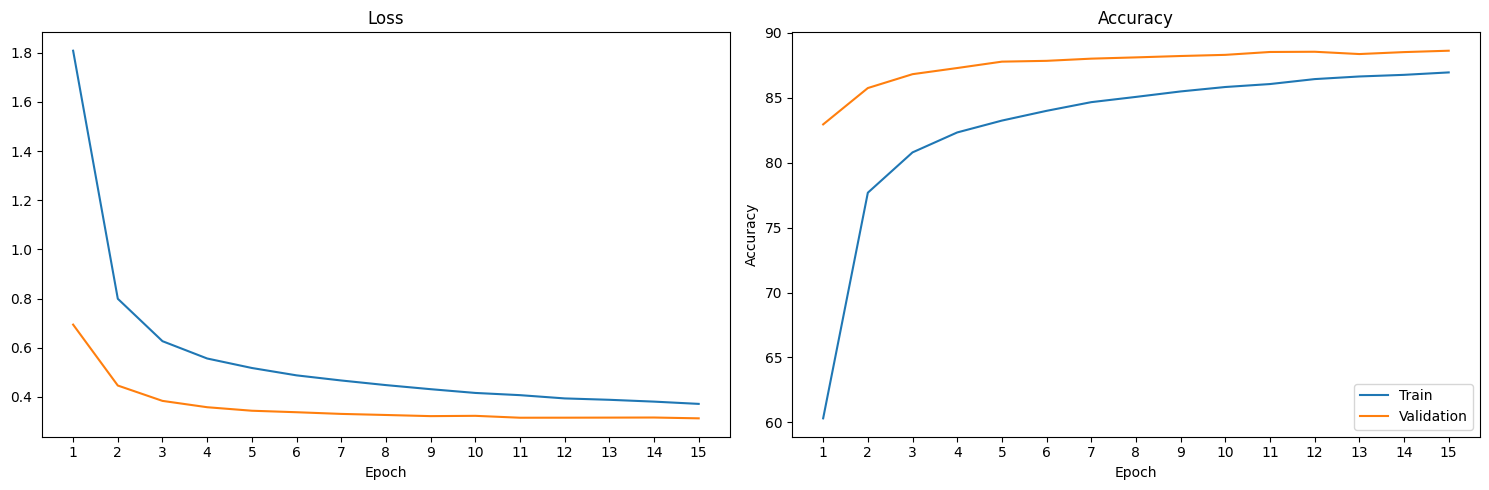

test_loss=0.3368499310826566 and test_accuracy =88.28191489361703


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▆▆▇▇▇▇████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇▇██████
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
best_val_acc,88.63475
epoch,14


wandb: Agent Starting Run: 4udug5ro with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.4228398985871273
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 5.639243222208777e-05
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.383 | Train Acc = 87.00% | Validation Loss = 0.340 | Validation Acc = 87.72% : 100%|██████████| 15/15 [06:48<00:00, 27.22s/it]


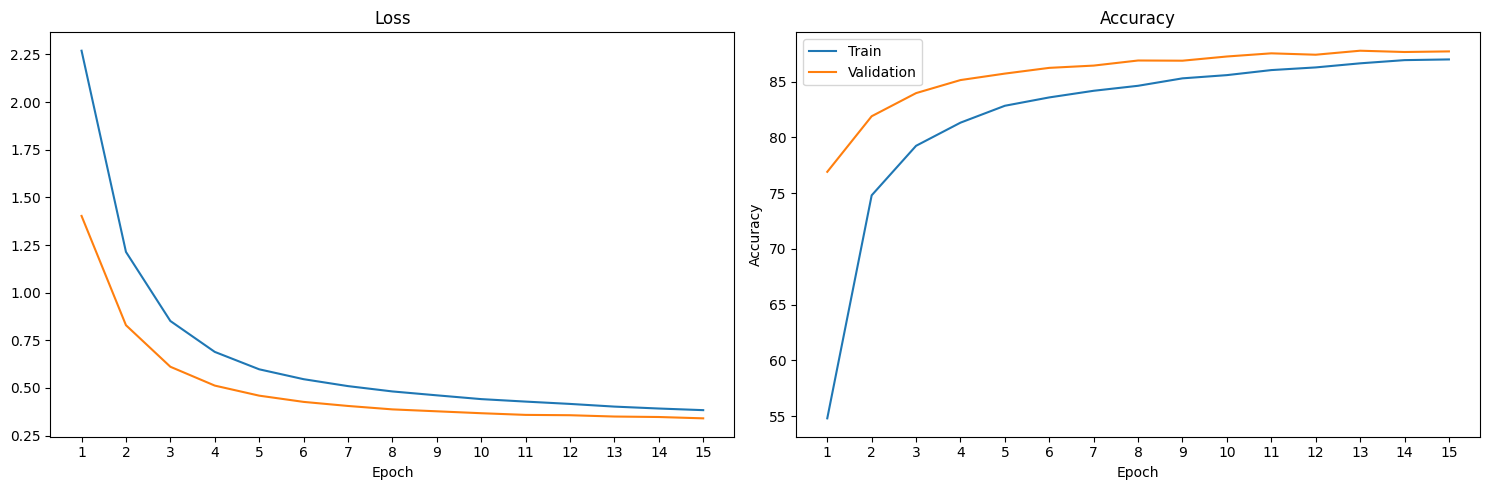

test_loss=0.3709993198716722 and test_accuracy =87.16489361702128


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇▇▇▇▇███████
train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇▇██████
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁
best_val_acc,87.77926
epoch,14


wandb: Agent Starting Run: 0jhviggc with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.3679542839272878
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 3.633215146308249e-05
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.507 | Train Acc = 83.62% | Validation Loss = 0.378 | Validation Acc = 87.17% : 100%|██████████| 15/15 [07:57<00:00, 31.82s/it]


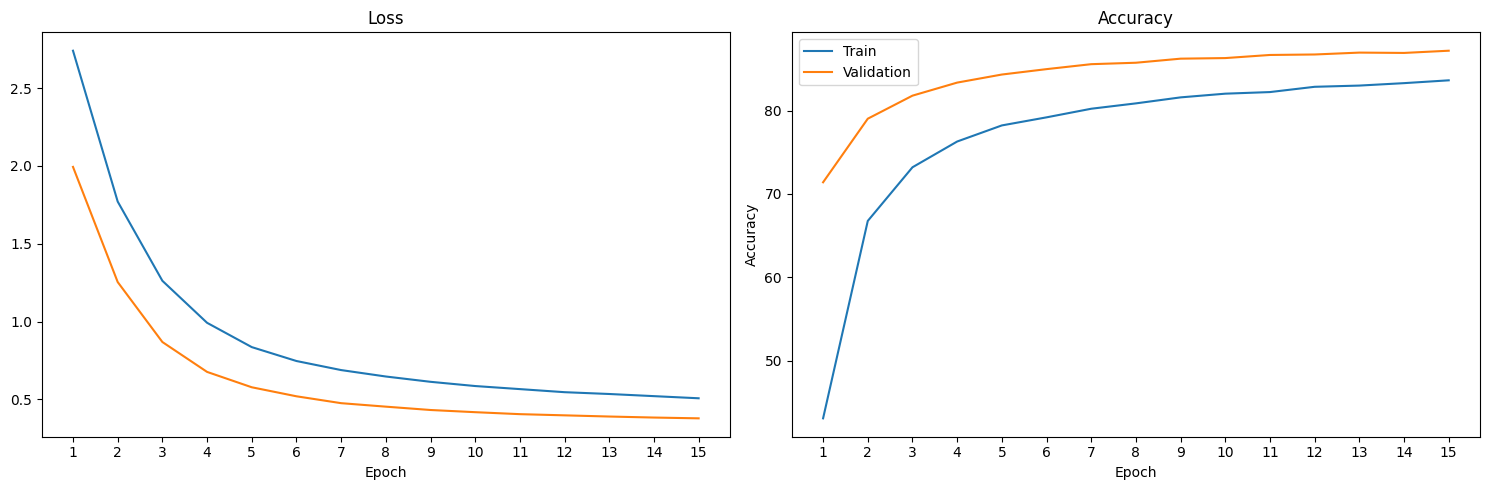

test_loss=0.39860127682537855 and test_accuracy =86.52659574468085


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇▇▇▇████████
train_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇███████
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
best_val_acc,87.16755
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h4a6u5pd with config:
wandb: 	batch_size: 64
wandb: 	dense_units: 64
wandb: 	dropout_rate: 0.49909293417892303
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.00019091444661471703
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.468 | Train Acc = 84.20% | Validation Loss = 0.345 | Validation Acc = 87.98% : 100%|██████████| 15/15 [06:48<00:00, 27.21s/it]


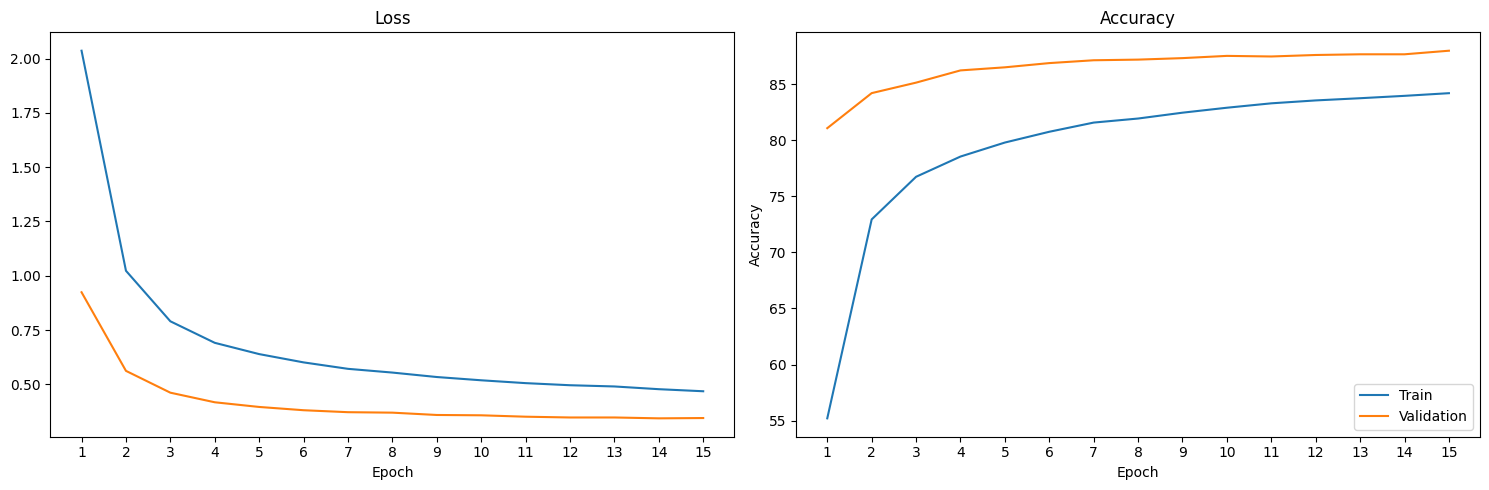

test_loss=0.3610852855656828 and test_accuracy =87.55851063829788


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇▇▇▇▇███████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇█▇████
val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
best_val_acc,87.98316
epoch,14


wandb: Agent Starting Run: pegu8pqs with config:
wandb: 	batch_size: 16
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.4950592257606434
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 7.565722577102747e-05
wandb: 	num_conv_layers: 3
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.342 | Train Acc = 87.76% | Validation Loss = 0.307 | Validation Acc = 88.74% : 100%|██████████| 15/15 [10:50<00:00, 43.37s/it]


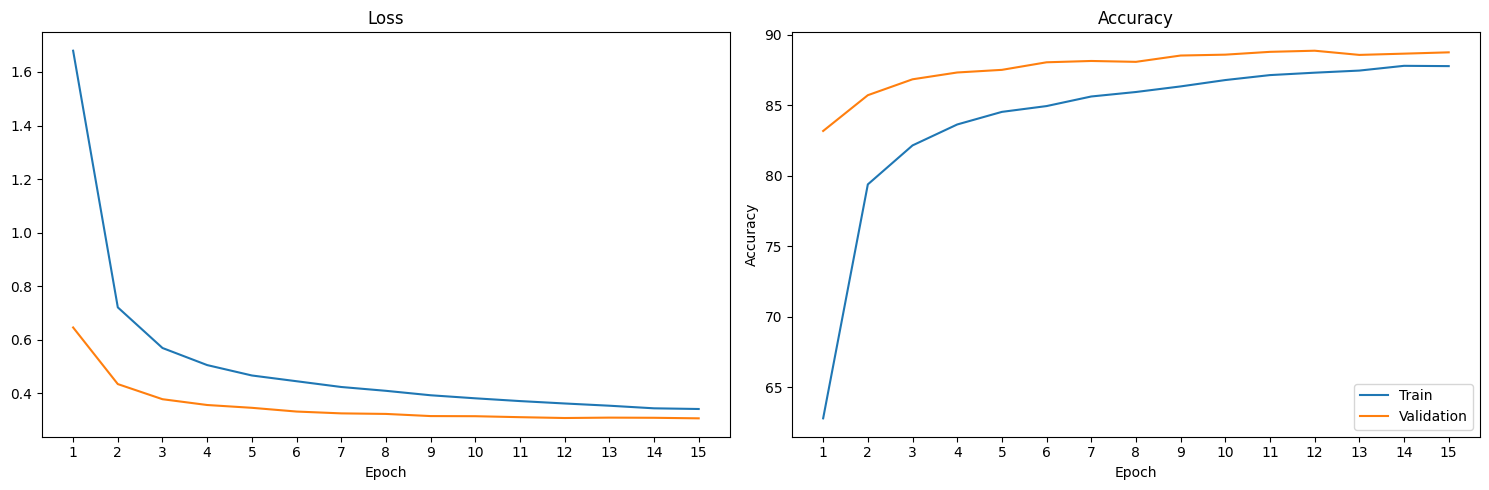

test_loss=0.3342329291436583 and test_accuracy =88.43085106382979


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▆▆▇▇▇▇▇███████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▆▇▇▇███████
val_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁
best_val_acc,88.85195
epoch,14


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 82hwi6cz with config:
wandb: 	batch_size: 32
wandb: 	dense_units: 128
wandb: 	dropout_rate: 0.4669188390845088
wandb: 	epochs: 15
wandb: 	filters: 16
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.00022454791489081745
wandb: 	num_conv_layers: 2
wandb: 	optimizer: Adam
wandb: 	padding: 1
wandb: 	pool_size: 2
wandb: 	stride: 1
wandb: 	train_ratio: 80


Using device: cuda


Train Loss = 0.326 | Train Acc = 88.22% | Validation Loss = 0.313 | Validation Acc = 88.68% : 100%|██████████| 15/15 [07:56<00:00, 31.75s/it]


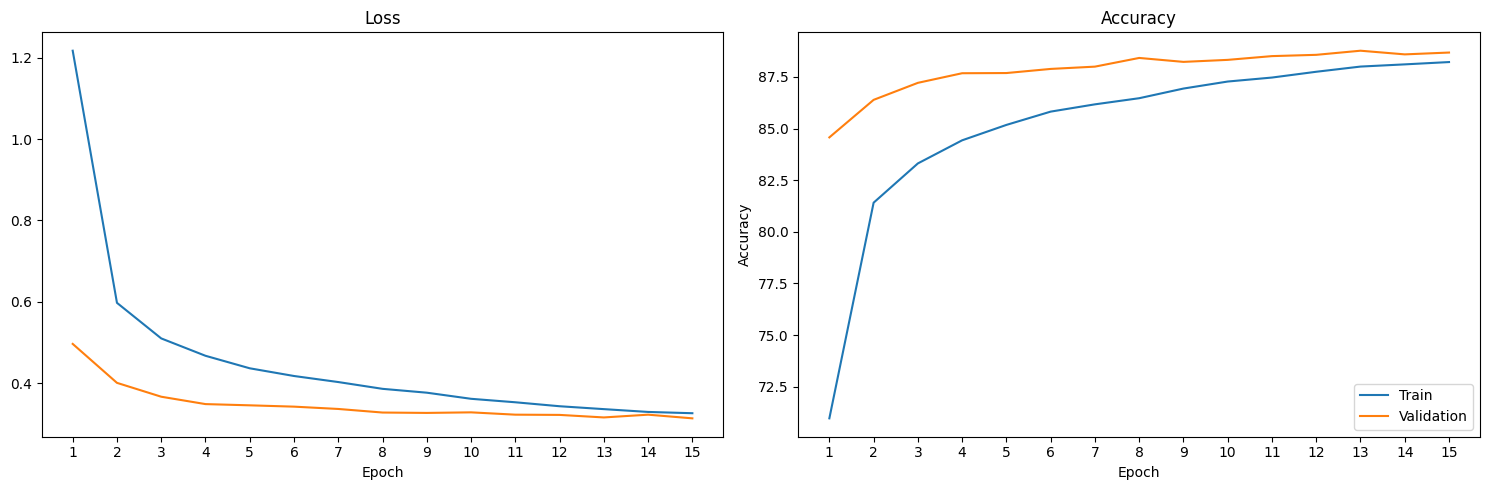

test_loss=0.33380922360890575 and test_accuracy =88.47872340425532


best_val_acc,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁
train_acc,▁▅▆▆▇▇▇▇▇██████
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇▇█████
val_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁
best_val_acc,88.77216
epoch,14


Sweep completed!


In [ ]:
import wandb
# First, make sure WandB is properly initialized
wandb.login()  # Will prompt for API key if needed
# Get current entity
api = wandb.Api()
current_entity = api.default_entity
count=20
# Create sweep configuration
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'distribution': 'log_uniform_values',
            'min': 1e-6,
            'max': 1e-2
        },
        'optimizer': {
            'values': ['Adam', 'SGD']
        },
        'batch_size': {
            'values': [8, 16, 32, 64, 128]
        },
        'num_conv_layers': {
            'values': [2,3, 4]
        },
        'filters': {
            'values': [16, 32]
        },
        'kernel_size': {
            'values': [3, 5]
        },
        'dropout_rate': {
            'distribution': 'uniform',
            'min': 0.2,
            'max': 0.5
        },
        'dense_units': {
            'values': [32,64, 128]
        },
        'epochs': {
            'value': 15
        },
        'train_ratio': {
            'value': 80
        },
        'stride': {
            'value': 1
        },
        'padding': {
            'value': 1
        },
        'pool_size': {
            'value': 2
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep=sweep_config,project="sweep-cnn",entity=current_entity)
print(f"Sweep ID: {sweep_id}")
print(f"Starting {count} runs for hyperparameter sweep...")
# Start the sweep agent
wandb.agent(sweep_id,function=train_model,count=count)

print("Sweep completed!")


the analysis of 20 hyperparameter configurations for a convolutional neural network (CNN) on a character recognition task revealed the key settings for optimal performance, which reached up to 88.48% test accuracy.

**Most Important Findings:**

* Learning Rate: This was the most critical hyperparameter. The optimal range was very narrow (0.000065 to 0.00022). Values below this range caused a dramatic collapse in model performance.

* Optimizer: The Adam optimizer significantly and consistently outperformed SGD for this specific task.

* Model Architecture: Contrary to common assumptions, a simpler model with 16 convolutional filters and 5x5 kernels yielded better results than a larger one with 32 filters or smaller 3x3 kernels.

* Regularization: Higher dropout rates (between 0.41 and 0.50) improved performance, suggesting that stronger regularization was beneficial for this dataset.

**Less Impactful Factors:**

* Batch size, the number of convolutional layers (2-3 were sufficient), and the number of units in the dense layer had minimal impact on performance within the tested ranges.

**Key Recommendation:**
For this task, prioritizing a precise learning rate within the optimal range, using the Adam optimizer, and selecting a simpler, well-regularized architecture (16 filters, 5x5 kernels, high dropout) is more effective than simply increasing the model's complexity.

